In [1]:
import numpy as np
import random
n_qubits=6
import matplotlib.pyplot as plt

In [2]:
X=np.array([[0,1],[1,0]])
Y=np.array([[0,-1j],[1j,0]])
Z=np.array([[1,0],[0,-1]])
H=np.array([[1,1],[1,-1]])/np.sqrt(2)
CNOT_ideal=np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
CNOT_ideal_1=np.array([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]])
I=np.eye(2)
def Fidelity(a,b):
    return np.real(np.trace(a@b)+2*np.sqrt(np.linalg.det(a)*np.linalg.det(b)))
def Rz(theta):
    return np.array([[np.exp(-1j*theta/2),0],[0,np.exp(1j*theta/2)]])
def Ry(theta):
    return np.array([[np.cos(theta/2),-np.sin(theta/2)],[np.sin(theta/2),np.cos(theta/2)]])
def Cnot(control=0):
    if control==0:
        return CNOT_ideal
    return CNOT_ideal_1
def Cnot_global(control=0,layer=0):
    if layer==0:
        gate=np.array([1])
        for j in range((n_qubits-1)*i,int(n_qubits/2)+(n_qubits-1)*i):
            gate=np.kron(gate,Cnot(control=control))
        return gate
    gate=I
    for j in range(int(n_qubits/2)+(n_qubits-1)*i,n_qubits-1+(n_qubits-1)*i):
        gate=np.kron(gate,Cnot(control=control))
    gate=np.kron(gate,I)
    return gate
    
#generating random hamiltonian and initial state

def phi(): #random phi and theta
    return random.random()*2*0.1
def theta():
    return -random.random()*0.1+np.pi
def get_psi(n_qubits):
    psi = np.reshape((2*(np.random.randn(2**n_qubits)-0.5) + 2j*(np.random.rand(2**n_qubits)-0.5)), (2**n_qubits,1))
    psi=psi/(np.sqrt(psi.conjugate().T@psi))
    return psi


    
phi_m=np.array([phi() for i in range(int(n_qubits*(n_qubits-1)/2))])
theta_m=np.array([theta() for i in range(int(n_qubits*(n_qubits-1)/2))])
psi0=get_psi(n_qubits)
rho0=psi0@psi0.T.conjugate()

In [3]:
#Ideal case (without error)
def FSG_ideal(phi,theta):
    return np.array([[1,0,0,0],[0,-1j*np.sin(phi/2),np.cos(phi/2),0],[0,np.cos(phi/2),-1j*np.sin(phi/2),0],[0,0,0,np.exp(1j*theta)]])
def evol(error=0):
    psi=psi0
    for i in range(int(n_qubits/2)):
        F_layer=FSG_ideal(phi_m[i*(n_qubits-1)],theta_m[i*(n_qubits-1)])
        for j in range(1,int(n_qubits/2)):
            F_layer=np.kron(F_layer,FSG_ideal(phi_m[i*(n_qubits-1)+j],theta_m[i*(n_qubits-1)+j]))
        psi=F_layer@psi
        F_layer=np.eye(2)
        for j in range(int(n_qubits/2),int(n_qubits-1)):
            F_layer=np.kron(F_layer,FSG_ideal(phi_m[i*(n_qubits-1)+j],theta_m[i*(n_qubits-1)+j]))
        F_layer=np.kron(F_layer,np.eye(2))
        psi=F_layer@psi
    return psi
psi_errorless=evol()
rho_errorless=psi_errorless@(psi_errorless.T.conjugate())

In [4]:
#Evolution with error

def error_cnot(rho0,error_probability=0,layer=0,control=0):
    Cnot=Cnot_global(control=control,layer=layer)
    rho_cnot=Cnot@rho0@Cnot
    E=np.array([np.array([[1,0],[0,np.sqrt(1-error_probability)]]),np.array([[0,np.sqrt(error_probability)],[0,0]])])
    rho=np.zeros((2**n_qubits,2**n_qubits),dtype='complex')
    for i in range(2):
        for j in range(2):
            for m in range(2):
                for n in range(2):
                    for l in range(2):
                        for k in range(2):
                            U=np.kron(E[i],np.kron(E[j],np.kron(E[m],np.kron(E[n],np.kron(E[l],E[k])))))
                            rho+=U@rho_cnot@U.T.conjugate()
    return rho

def evolution1(rho0,error_probability=0):
    rho=rho0
    for i in range(int(n_qubits/2)):
        
        layer=np.array([1])
        for j in range((n_qubits-1)*i,int(n_qubits/2)+(n_qubits-1)*i):
            layer=np.kron(layer,I)
            layer=np.kron(layer,Rz(np.pi/2))
        rho=error_cnot(layer@rho@layer.T.conjugate(),error_probability=error_probability)
        
        layer=np.array([1])
        for j in range((n_qubits-1)*i,int(n_qubits/2)+(n_qubits-1)*i):
            layer=np.kron(layer,Ry(-phi_m[j]/2))
            layer=np.kron(layer,Rz(-theta_m[j]/2))
        rho=error_cnot(layer@rho@layer.T.conjugate(),error_probability=error_probability,control=1)
        
        layer=np.array([1])
        for j in range((n_qubits-1)*i,int(n_qubits/2)+(n_qubits-1)*i):
            layer=np.kron(layer,Rz((theta_m[j]-np.pi)/2)@Ry(phi_m[j]/2))
            layer=np.kron(layer,I)
        rho=error_cnot(layer@rho@layer.T.conjugate(),error_probability=error_probability)
        
        layer=np.array([1])
        for j in range((n_qubits-1)*i,int(n_qubits/2)+(n_qubits-1)*i):
            layer=np.kron(layer,I)
            layer=np.kron(layer,Rz(theta_m[j]/2))
        rho=layer@rho@layer.T.conjugate()
        
        
        
        layer=I
        for j in range(int(n_qubits/2)+(n_qubits-1)*i,n_qubits-1+(n_qubits-1)*i):
            layer=np.kron(layer,I)
            layer=np.kron(layer,Rz(np.pi/2))
        layer=np.kron(layer,I)
        rho=error_cnot(layer@rho@layer.T.conjugate(),error_probability=error_probability,layer=1)
        
        layer=I
        for j in range(int(n_qubits/2)+(n_qubits-1)*i,n_qubits-1+(n_qubits-1)*i):
            layer=np.kron(layer,Ry(-phi_m[j]/2))
            layer=np.kron(layer,Rz(-theta_m[j]/2))
        layer=np.kron(layer,I)
        rho=error_cnot(layer@rho@layer.T.conjugate(),error_probability=error_probability,layer=1,control=1)
        
        layer=I
        for j in range(int(n_qubits/2)+(n_qubits-1)*i,n_qubits-1+(n_qubits-1)*i):
            layer=np.kron(layer,Rz((theta_m[j]-np.pi)/2)@Ry(phi_m[j]/2))
            layer=np.kron(layer,I)
        layer=np.kron(layer,I)
        rho=error_cnot(layer@rho@layer.T.conjugate(),error_probability=error_probability,layer=1)
        
        layer=I
        for j in range(int(n_qubits/2)+(n_qubits-1)*i,n_qubits-1+(n_qubits-1)*i):
            layer=np.kron(layer,I)
            layer=np.kron(layer,Rz(theta_m[j]/2))
        layer=np.kron(layer,I)
        rho=layer@rho@layer.conjugate().T
    return rho 

In [5]:
%%time
n_dots=50
x=np.linspace(0,0.0005,n_dots)
y=np.zeros(n_dots)
for i in range(n_dots):
    y[i]=Fidelity(evolution1(rho0,error_probability=x[i]),rho_errorless)

Wall time: 15.1 s


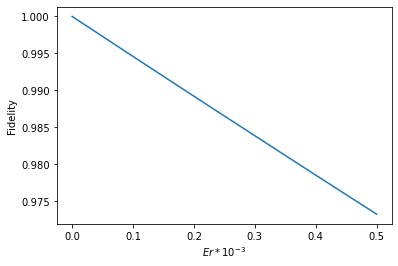

In [6]:
plt.plot(x*1000, y, '-')
plt.xlabel('$Er*10^{-3}$')
plt.ylabel('Fidelity')
plt.show()

In [7]:
file = open("error_digital_amplitude.txt", "w")
for i in y:
    file.write(str(i)+"\n")
file.close()